From the HyMoLAP_GR4 model, we build the following SDE model in the L0123001 catchment:

$$
dQ(t)=\left[-\frac{\mu}{\lambda} Q(t)^{2\mu-1}+\frac{1}{\lambda} Perc(t) Pn(t)\right]dt+ \sigma P(t)dW(t)
$$

with the discrete form using the Euler-Maruyama method:

$$
Q_{t+1} = Q_{t} -\frac{\mu}{\lambda} Q_t^{2\mu-1} +\frac{1}{\lambda} Perc_t \times Pn_t + \sigma P_t \Delta W_t
$$

where:
- $Q(t)$ is the discharge at time $t$,
- $Perc(t)$ is the percolation at time $t$,
- $Pn(t)$ is the net precipitation,
- $P(t)$ is the precipitation at time $t$,
-  $\sigma$ is the SDE model diffuion parameter,
- $W(t)$ is a Wiener process,
- and $\Delta W_t \sim \mathcal{N}(0, \Delta t=1)$.

In [15]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from numpy import concatenate

import math

import joblib
import matplotlib.dates as mdates
from google.colab import files

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/airGR_L0123001.csv')

daily.head()

,Unnamed: 0,DatesR,P,T,E,Qls,Qmm
0,1,1984-01-01,4.1,0.5,0.2,2640.0,0.6336
1,2,1984-01-02,15.9,0.2,0.2,3440.0,0.8256
2,3,1984-01-03,0.8,0.9,0.3,12200.0,2.9280
3,4,1984-01-04,0.0,0.5,0.3,7600.0,1.8240
4,5,1984-01-05,0.0,-1.6,0.1,6250.0,1.5000


In [18]:
#Calibration data
discharge = daily.iloc[5114:7671, -1].to_numpy()
plui = daily.iloc[5114:7671, 2].to_numpy()
etp = daily.iloc[5114:7671, 4].to_numpy()

#Validation data
discharge1 = daily.iloc[7671:8766, -1].to_numpy()
plui1 = daily.iloc[7671:8766, 2].to_numpy()
etp1 = daily.iloc[7671:8766, 4].to_numpy()

In [19]:
discharge[0]

0.3144

In [20]:
discharge[-1]

0.8112

In [21]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J-HyMoLAP

In [22]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [23]:
#  model calibration : Here we chose the below ranges and then the optimal values found were:  mu = 0.9756486900089809, lambda_ = 6.261137845168766, X1 = 99.62821160899779,
# following the same calibration process with the HyMoLAP above.
Pn = plui - etp
Pn[Pn < 0] = 0

En = etp - plui
En[En < 0] = 0

nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1):
      mu = 0.9756486900089809 #(1.4 - 0.5) * np.random.rand() + 0.5
      lambda_ = 6.261137845168766 #(10 - 1) * np.random.rand() + 1
      X1 = 99.62821160899779 #(100 - 70) * np.random.rand() + 70

      Perc = Percolation(Pn, En, X1)

      for k in range(0, len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]

      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()

print(nse)

0.6708540197644917


In [24]:
print('nashe=',nash_sutcliffe_efficiency(discharge[1:],  GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:],  GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:],  GR4J_HyM[1:]))

nashe= 0.6708540197644917
rmse= 0.8935489568574768
r2= 0.7273633888404886


Validation

In [25]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [26]:
# Simulation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)

#EQUATION
Qval = np.zeros(size)
Qval[0] = discharge1[0]

for k in range(0, size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]

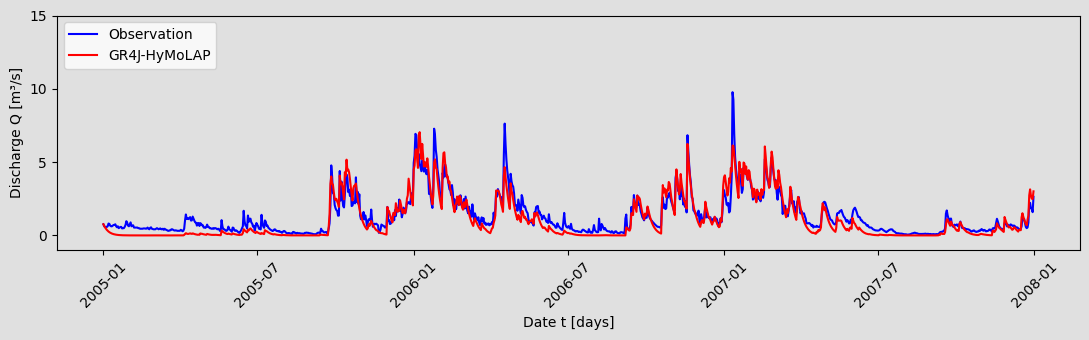

In [27]:
# Generate the dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Set background color
fig.patch.set_facecolor('#e0e0e0')
ax.set_facecolor('#e0e0e0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
ax.plot(time, Qval, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date t [days]')

# Y-axis settings
ax.set_ylabel('Discharge Q [m³/s]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add the legend
ax.legend(loc='upper left')

# Show grid (currently commented out)
# plt.grid(True)

# Adjust layout to avoid overlaps
plt.tight_layout()

# Save the figure
plt.savefig("hyM_save_val2.jpeg", format='jpeg', dpi=500)

# Display the plot
plt.show()


In [28]:
nse_value = nash_sutcliffe_efficiency(discharge1, Qval)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qval)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qval)
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8324726667854867
rmse= 0.5458726450387722
r2= 0.8806127591849476


SDE

In [30]:
# Compute the diffusion parameter

Perc = Percolation(Pn, En, X11)

num = 0
den = 0
for k in range(1, len(discharge)):
  num = num + (discharge[k] - discharge[k - 1] + (mu1/lambda1) * discharge[k-1]**(2*mu1-1) - (1/lambda1) * Perc[k-1] * Pn[k - 1])**2
  den = den + (plui[k-1])**2

sigma = np.sqrt(num/den)

In [31]:
print(sigma)

0.06493043114233762


UQ

In [33]:
# Simulation with the SDE
size = len(discharge)
n_traj = 10000
QQ = np.zeros((size,n_traj))

Perc = Percolation(Pn, En, X11)

for i in range(n_traj):

   # Model
   S = np.zeros(size)
   S[0] = discharge[0]

   for k in range(1, len(discharge)):
      if S[k - 1] < 0:
         S[k - 1] = 0

      S[k] = (S[k - 1] - (mu1/lambda1) * S[k-1]**(2*mu1-1) + (1/lambda1) * Perc[k-1] * Pn[k-1] +
                     sigma * (plui[k-1]) * np.random.normal(loc=0, scale=np.sqrt(1)))

   QQ[:, i] = S.copy()

mean_trajectory = np.mean(QQ, axis=1)


In [34]:
nse_value = nash_sutcliffe_efficiency(discharge[1:], mean_trajectory[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], mean_trajectory[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.6988122984264598
rmse= 0.8547570500082586


In [35]:
# Build 90% quantile interval
min_trajectory = np.percentile(QQ, 5, axis=1)
max_trajectory = np.percentile(QQ, 95, axis=1)

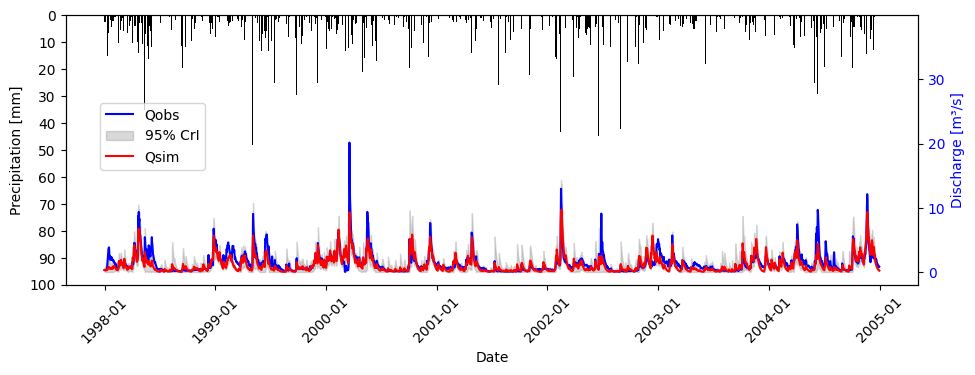

In [36]:
# Create a date range from '1998-01-01' to '2004-12-31'
time1 = np.datetime64('1998-01-01')
time2 = np.datetime64('2004-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and primary axis with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot precipitation as a bar chart on ax1
ax1.bar(time, plui, color='black')

# Format x-axis labels (date format)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 10))

# Invert y-axis for precipitation (so bars go downwards)
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a secondary y-axis to plot discharge
ax2 = ax1.twinx()

# Plot observed discharge
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot uncertainty band (min and max values) as shaded region
ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot mean simulated discharge trajectory
ax2.plot(time, mean_trajectory, 'red', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-2, 40)
ax2.set_yticks(np.arange(0, 40, 10))

# Add a combined legend inside the figure
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Show grid (currently commented out)
# plt.grid(True)

# Display the plot
plt.show()


In [37]:
observed = discharge
lower_bound = min_trajectory
upper_bound = max_trajectory

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")


Hit Rate (HR) in %: 73.914743840438
Mean Prediction Interval Width (MPIW): 1.634813907994854


Validation

In [38]:
# Simulation with the SDE
size1 = len(discharge1)
n_traj = 100000
QQ1 = np.zeros((size1,n_traj))

Perc1 = Percolation(Pn1, En1, X11)

for i in range(n_traj):

   # Model
   S1 = np.zeros(size1)
   S1[0] = discharge1[0]

   for k in range(1, len(discharge1)):
      if S1[k - 1] < 0:
         S1[k - 1] = 0

      S1[k] = (S1[k - 1] - (mu1/lambda1) * S1[k-1]**(2*mu1-1) + (1/lambda1) * Perc1[k-1] * Pn1[k-1] +
                     sigma * (plui1[k-1]) * np.random.normal(loc=0, scale=np.sqrt(1)))

   QQ1[:, i] = S1.copy()

mean_trajectory1 = np.mean(QQ1, axis=1)


In [39]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], mean_trajectory1[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], mean_trajectory1[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.8554991925609208
rmse= 0.5071623582496625


In [40]:
# Build 90% quantile interval
min_trajectory1 = np.percentile(QQ1, 5, axis=1)
max_trajectory1 = np.percentile(QQ1, 95, axis=1)

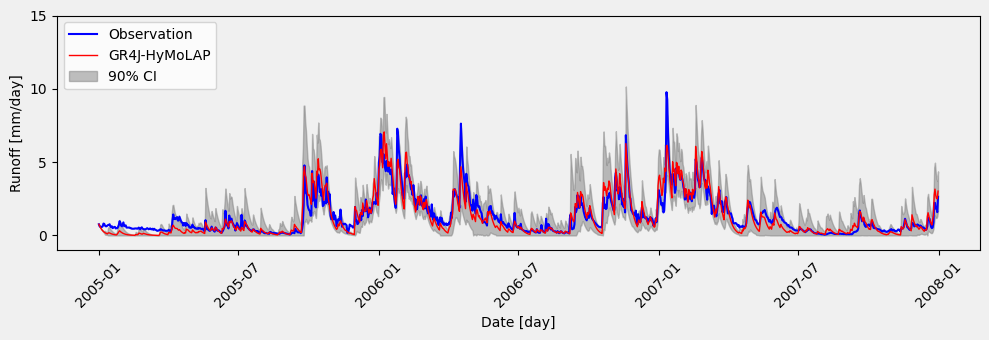

In [43]:
# Generate dates from 2005-01-01 to 2007-12-31
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10., 3.5))

# Set background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
ax.plot(time, mean_trajectory1, color='red', linestyle='-', label='GR4J-HyMoLAP', linewidth=1.)

# Plot confidence interval (min and max values) as shaded region
ax.fill_between(time, min_trajectory1, max_trajectory1, color='gray', alpha=0.5, label='90% CI')

# Configure x-axis (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Configure y-axis
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add legend
ax.legend(loc='upper left')

# Show grid (commented out)
# plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save figure with high resolution
plt.savefig("UQ.jpeg", format='jpeg', dpi=500)

# Download the image (for Colab use)
#files.download('UQ.jpeg')

# Display the plot
plt.show()


In [42]:
observed = discharge1
lower_bound = min_trajectory1
upper_bound = max_trajectory1

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")

Hit Rate (HR) in %: 84.20091324200914
Mean Prediction Interval Width (MPIW): 1.6620851791106042
